# OpenCVpythonMeasurePlanarObjects

Pinhole cameras are widely used for computer vision tasks because price accessibility and the features that can be extracted form an image are rich enough about the environment information. The relationship between world points and the camera points is given by the following matrix equation.

$\alpha \begin{bmatrix}x_c \\y_c \\1\end{bmatrix}= MR
\begin{bmatrix}
x_w \\
y_w \\
z_w \\
\end{bmatrix}
+t
$

$M = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}; \quad
R = \begin{bmatrix}
r_{x,1} & r_{x,2} & r_{x,3} \\
r_{y,1} & r_{y,2} & r_{y,3} \\
r_{z,1} & r_{z,2} & r_{z,3}
\end{bmatrix}; \quad
t = \begin{bmatrix}
t_x \\
t_y \\
t_z
\end{bmatrix}$

Here $x_c$ and $y_c$ are the coordinates of a point in the camera plane, corresponding to a point located in the real world plane given by $x_w$, $y_w$ and $z_w$ coordinates. The matrix $M$ is known as the camera matrix, which corresponds to the intrinsic parameters, which are the focal lengths $f_x$ and $f_y$, and the optical centers $c_x$ and $c_y$. The matrix $R$ and vector $t$ are the extrinsic parameters which gives the information about the relative position of the camera, that is, the rotation form the origin of the real world plane and also the traslation from the origin of that plane. Finally $\alpha$ is the scale factor that accounts for the distance from the camera to the real world coordinate.

However, pinhole cameras have some issues related to the distortion of the image because of the lens used. First a camera can present a distortion due to the lens inside it, this distortion becomes evident near the edges of the camera. The distrotion created by this effect, follows the equation below

\begin{equation}
\begin{array}{c}
x_{distorted} = x_c\left(1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right) 
\\
y_{distorted} = y_c\left(1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right) 
\end{array}
\end{equation}
where the $r^2 = x^2 + y^2$ and $k_1,\hspace{2mm}k_2$ and $k_3$ are de distortion coefficients.

The same applies to the tangential distortion, which is a consequence of the deviation of the camera lens, i.e., the lens is not parallel to the plane of the sensor. The behavior is modelled by the following equation
\begin{equation}
\begin{array}{c}
x_{distorted} = x + \left( 2p_1 xy + p_2\left( r^2 + 2x^2 \right) \right) 
\\
y_{distorted} = y + \left( 2p_2 xy + p_1\left( r^2 + 2y^2 \right) \right) 
\end{array}
\end{equation}
where $p_1$ and $p_2$ are the tangential distortion coefficients

The principal objective is to find the pattern in the image detected by the camera and then translate the camera coordinates to the real world coordinates.

OpenCV is a programming language focus on Computer Vision tasks. It offer different functionalites for image and video processing together with the versatility for its implementation on different language programmings such as Python and C++. The latter feature is important for developing image processing tasks in embedding systems such as the raspberry pi. On the other hand, MATLAB have a well developed software for the implementation of computer vision tasks, but the problem is the lack of compatibility with embedding systems and autonomous systems and also the processing time needed for its implementation.

OpenCV does not have an application or function that can measure planar objects from a detected plane as MATLAB, so the programs developed in MATLAB will be trnslated to OpenCV in python to accomplish the same task. 

First wee need to compute the intrinsic parameters of the camera. for this, we need  a series of images with a calibration pattern, i.e. a chessboard table. The chessboard table need to be in a distance similarly in which the camera will be used and in different positions and orientations. Here we use 30 images of the chessboard with different orientations. However, the number of images can vary from camera to camera. An important remark is  that the autofocus need to be deactivated to preserve the coefficients obtained for the intrinsic matrix. Some of the examples use for the image calibration are shown 

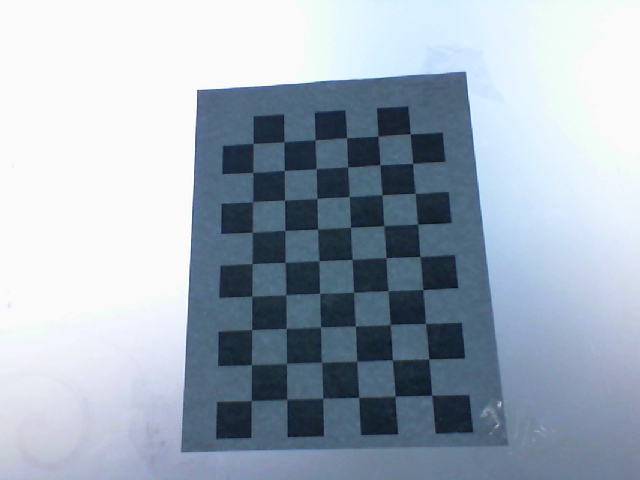

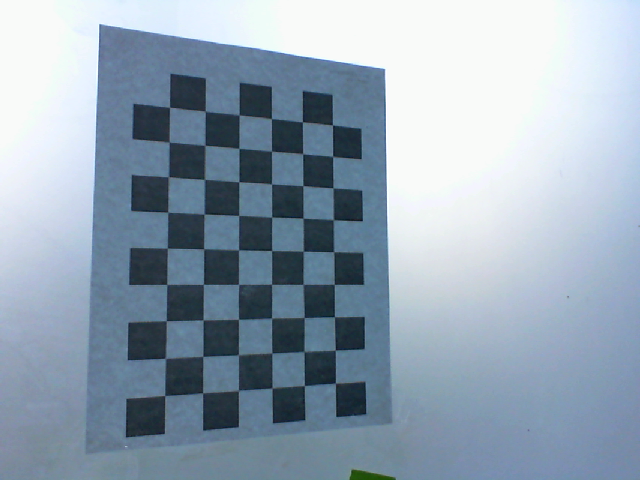

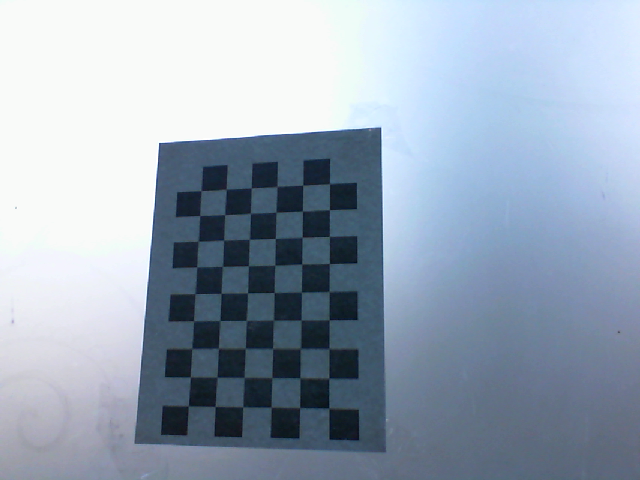


The program, modified from https://stackoverflow.com/questions/34588464/python-how-to-capture-image-from-webcam-on-click-using-opencv, open the camera and sets the parameters of the camera. However, there are some functions that OpenCV does not have such as the autofocus adjustment, which needs to be set manually from the prompt window.

If a "SPACE" key is press, an image is taken and saved into the current workspace. It is easy to find that the directory can be changed to another one, but in this case for simplicity, we set it in this way. Finally, in order to exit the program, we need to press the "ESC" key.

After the images are taken, we use the calibration function form OpenCV that computes the camera matrix and the distrotion coefficients by means fo the Levenberg-Marqudt algorithm. Once the camera matrix is computed, is saved along with the distortion coefficients which are invariant from the camera position and orientation.

In [ ]:
import cv2

cam = cv2.VideoCapture(1)
#Camera parameters
cam.set(11,0)
cam.set(3,640) #Width
cam.set(4,480) #Height

cv2.namedWindow("Preview")
#Create a window to preview the images

img_calibration = 0
#Creates the calibration numerator to take images

while True:
    ret, frame = cam.read()#take a picture
    #Verify if the image was taken
    if not ret:
        print("failed to grab frame")
        break #Exit the application
    
    cv2.imshow("Preview", frame)
    #Show the image in the created window
    k = cv2.waitKey(1)
    #Wait for a key commans every milisecond
    #If a key is pressed, the following condition are asked
    if k%256 == 27:
        print("Calibration Image Adquisition Finished")
        break
    elif k%256 == 32:
        img_name = "Calibration{}.png".format(img_calibration)
        cv2.imwrite(img_name, frame)
        print("{} saved!".format(img_name))
        img_calibration += 1
        

cam.release()

cv2.destroyAllWindows()

: 

In order to transform coordinates from the camera to the real world, we first need to select the coordnates. Thus, a color detection tasks is used for finding two markers from the scene and then compute the real distance between them.

The contrast of the camera is set to 0, an the BGR space is converted to the HSV space, in order to reduce the effect of the illumination form the scene. The selected upper and lower bounds for the HSV space are in table. After the boundaries are applied into the scene, morphological operations, i.e. an opening operation with a kernel of size 5, are used to eliminate noise from the resultant binary image.

Finally, from the binary image we can obtain the contours, then, the image moments are computed. Image moments give statistical information about the contours of a shape inside an image. Then, we can extract the center of the contours detected based on them.

In [ ]:
import numpy as np
import cv2 as cv
import glob
from tempfile import TemporaryFile

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
squareSize=24.3
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)*squareSize#milimetros
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('*.png')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (9,6), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(100)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv.imread('Calibration0.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
#cv.imwrite('Z.png', dst)
# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
# undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

with open('mtx.npy', 'wb') as f:
    np.save(f, mtx)
with open('rvecs.npy', 'wb') as f:
    np.save(f, rvecs)
with open('tvecs.npy', 'wb') as f:
    np.save(f, tvecs)
with open('dist.npy', 'wb') as f:
    np.save(f, dist)
    
cv.destroyAllWindows()

### Color Detection

In order to transform coordinates from the camera to the real world, we first need to select the coordnates. Thus, a color detection tasks is used for finding two markers from the scene and then compute the real distance between them.

The contrast of the camera is set to 0, an the BGR space is converted to the HSV space, in order to reduce the effect of the illumination form the scene. The selected upper and lower bounds for the HSV space are in table \ref{tab:HSVValues}. After the boundaries are applied into the scene, morphological operations, i.e. an opening operation with a kernel of size 5, are used to eliminate noise from the resultant binary image.

\begin{table}[h!]
    \centering
    \begin{tabular}{ |c|c|c| }
 \hline 
  & Upper & Lower \\
 \hline 
 H & 90 & 60 \\ 
 S & 255 & 100 \\ 
 V & 255 & 100 \\ 
 \hline
    \end{tabular}
    \caption{Upper and lower bounds selected}
    \label{tab:ErrorResults}
\end{table}

Finally, from the binary image we can obtain the contours, then, the image moments are computed. Image moments give statistical information about the contours of a shape inside an image. Then, we can extract the center of the contours detected based on them.

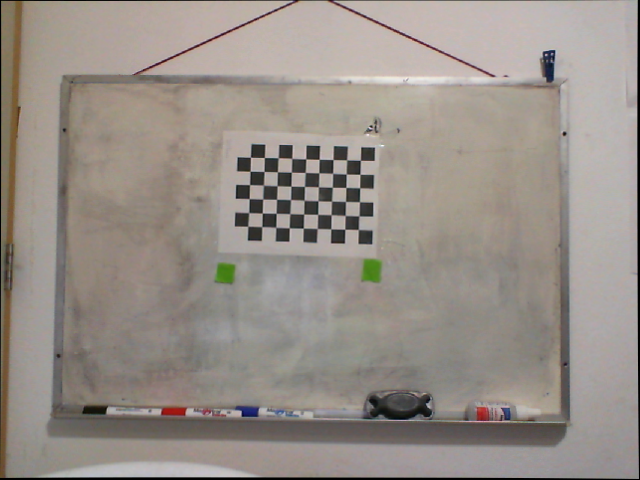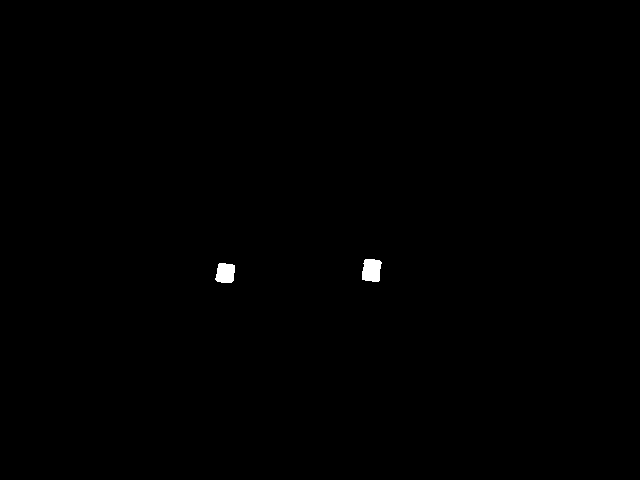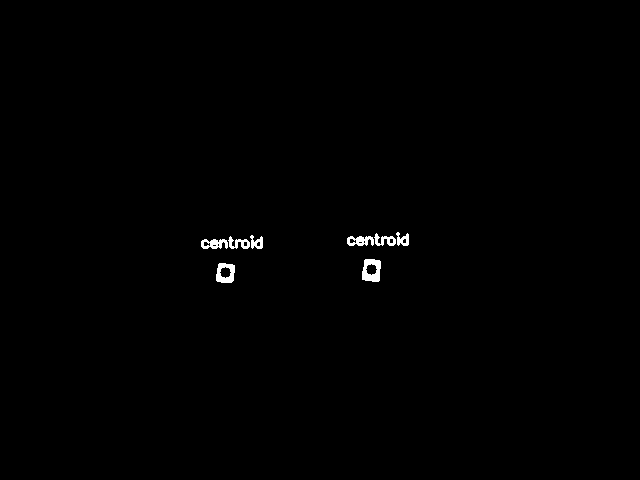

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import serial
import time
import cv2

cap = cv2.VideoCapture(0)
time.sleep(1)
cap.set(11,0)
cap.set(3,640) #Width
cap.set(4,480) #Height
cap.set(cv2.CAP_PROP_BRIGHTNESS,0)
#IMPORTANTE. SIEMPRE QUITAR EL AUTOFOCUS v4l2-ctl -c focus_auto=0

#####Obtener posicion del tablero
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)*24.3#milimetros
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

with open('mtx.npy', 'rb') as f:
    mtx = np.load(f)
with open('dist.npy', 'rb') as f:
    coef = np.load(f)
FLAG = True
while FLAG:
    _, frame = cap.read() #Take picture
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, coef)
        R = cv2.Rodrigues(rvecs)[0]
        R = np.concatenate((R[:,0:2],tvecs),axis=1)
        cv2.drawChessboardCorners(frame, (9,6), corners2, ret)
        #Undistort
        h,  w = frame.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, coef, (w,h), 1, (w,h))
        #En Undistort
        cv2.imshow('img', frame)
        cv2.waitKey(1)
        FLAG = False

########

kernel = np.ones((5,5),np.uint8)
###definir los limites

lower_green = np.array([40,50,50])
upper_green = np.array([65,255,255])

#Create database
results = pd.DataFrame()
temp = {}



for steps in range(100):
    _, frame = cap.read()
    frame = cv2.undistort(frame, mtx, coef, None, newcameramtx)
    frameHsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(frameHsv,lower_green,upper_green)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    contours,hierarchy = cv2.findContours(opening,cv2.RETR_TREE
                                                  ,cv2.CHAIN_APPROX_SIMPLE)
    cameraPointsA = np.reshape(np.array([imgpoints[0][1][0,0],imgpoints[0][1][0,1],1]),(-1,1))
    realPointsA = R@np.linalg.inv(mtx)@(cameraPointsA)
    if len(contours)==2:
        M1 = contours[0]
        M2 = contours[1]
        P1 = cv2.moments(M1)
        P2 = cv2.moments(M2)
        if P1['m00'] != 0 and P2['m00'] != 0:
            cX1 = int(P1['m10']/P1['m00'])
            cY1 = int(P1['m01']/P1['m00'])
            cX2 = int(P2['m10']/P2['m00'])
            cY2 = int(P2['m01']/P2['m00'])
            cameraPointsA = np.reshape(np.array([cX1,cY1,1]),(-1,1))
            realPointsA = np.linalg.inv(mtx@R)@(cameraPointsA)
            cameraPointsB = np.reshape(np.array([cX2,cY2,1]),(-1,1))
            realPointsB = np.linalg.inv(mtx@R)@(cameraPointsB)
            subs = np.array([realPointsA[0,0]/realPointsA[2,0] - realPointsB[0,0]/realPointsB[2,0],
                realPointsA[1,0]/realPointsA[2,0] - realPointsB[1,0]/realPointsB[2,0]])
            #subs = np.array([cX1 - cX2,cY1 - cY2])
            dist = np.sqrt(subs[0]*subs[0] + subs[1]*subs[1])
            temp['Distancia']=dist
            results = results.append(temp, ignore_index=True)
        for c in contours:
            M = cv2.moments(c)
            if M['m00'] != 0:
                cX = int(M['m10']/M['m00'])
                cY = int(M['m01']/M['m00'])
                cv2.circle(opening, (cX, cY), 5, (0, 0, 0), -1)
                cv2.putText(opening, "centroid", (cX - 25, cY - 25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    cv2.imshow('0',frame)
    cv2.imshow('1',mask)
    cv2.imshow('2',opening)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        time.sleep(1)
        break


results.to_csv('Results.csv')
results.plot()
plt.show()
cap.release()
cv2.destroyAllWindows()

### Measuring distance

To find the real world coordinates, equation \eqref{eq:PinholeTransformation} is solved. But first we need to calculate the camera extrinsic parameters, i.e. the rotation matrix and translation vector, then correct the distortion with the coefficients previously saved. First we turn out the autofocus of the camera manually with the instruction v4l2-ctl -c focus_auto=0

To find the extrinsic parameters, the program seeks for the chessboard pattern. In this case another function is used to compute the rotation and translation of the camera, rather than using the calibration procedure. With this parameters found, the next step is to correct the distortion produce by the camera lens.

Once the real world coordinates are computed, a simple euclidean distance is calculated. The resulting measure is stored in a pandas frame which is converted into a CSV file together with a plot of the resultant measures for further use.

### Results
The camera intrinsic parameters, along with the distortion coefficients obtained were

$
M = \begin{bmatrix}
585.03 & 0 & 312.02 \\
0 & 590.03 & 230.02 \\
0 & 0 & 1
\end{bmatrix}
$

To probe the efficiency of the algorithm we place markers into an approximate distance of 258 mm. In the first test, the camera was placed in front of the markers, without a relevant angle. the average measure were of 255.98 mm and a standard deviation of 0.75mm. From a n angle of approximately 45 degrees the measure was of 255.44 mm and a standard deviation of 0.047.



### Conclusions

The present lab report implement the algorithm for measure planar objects by a calibrated camera based on the algorithm implemented in MATLAB. The results are promising for implementing Computer Vision task in embedding systems such as the Raspberry pi which can be helpful for autonomous vehicles or robots.
